##### Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **V**ariational **I**ntrinsic **S**uccessor Featu**R**es
This is a minimal TensorFlow-v1 implementation of the VISR algorithm from [Fast Task Inference with Variational Intrinsic Successor Features](https://arxiv.org/abs/1906.05030) aimed at ease of understanding and usage rather than performance.


*   The (self-contained) environment is a 2D grid-world with 4 actions corresponding to the cardinal directions
*   VISR is trained here using batched environments and 1-step Q-learning
*   Should train in < 1 hour without a GPU
*   After training, fast inference can be performed in < 1 second on arbitrary reward functions
*   The code should be easily modifiable, but it advised to switch to a distributed training setup if attempting more complex environments (e.g. Atari)
*  The hyper-parameters and network architecture where chosen for simplicity, and could certainly be improved upon if performance on more complex grid-worlds is desired.



In [0]:
#@title Imports
%tensorflow_version 1.x
!pip install "dm-sonnet<2"
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sonnet as snt
from IPython.display import clear_output
from IPython.display import display
from IPython.display import HTML
%matplotlib inline

In [0]:
#@title Environmental Constants and Algorithm Hyperparameters
#constants
grid_size = 10
num_states = grid_size**2
num_a = 4
#hyper parameters
num_gpi_samples = 10
traj_len = 40
mb_size = 32
hid_dim = 100
phi_dim = 5
gamma = .95
epsilon = .1
lr = 1e-4

In [0]:
#@title Environment Definition and Helper Functions
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def sample_sphere(num_dim=phi_dim, size=None):
  if size is None:
    size = [traj_len, mb_size]
  unnormed = np.random.randn(*(size+[num_dim]))
  return unnormed / np.linalg.norm(unnormed, axis=-1, keepdims=True)

def reset(size=mb_size, start_state=None):
  if start_state is None:
    state = np.random.randint(num_states, size=size)
  else:
    state = start_state*np.ones([size], dtype=np.int)
  return state

def get_obs(state):
  return np.eye(num_states)[state]

def get_rc(state):
  row = state//grid_size
  col = state % grid_size
  return row, col

def get_s(row, col):
  return row*grid_size+col

def step(state, action):
  row, col = get_rc(state)
  #a0:up
  new_r = np.where(action == 0, row-1, row)
  #a1:left
  new_c = np.where(action == 1, col-1, col)
  #a2:down
  new_r = np.where(action == 2, new_r+1, new_r)
  #a3:right
  new_c = np.where(action == 3, new_c+1, new_c)
  #clip
  new_r[new_r >= grid_size] = grid_size-1
  new_r[new_r < 0] = 0
  new_c[new_c >= grid_size] = grid_size-1
  new_c[new_c < 0] = 0
  return get_s(new_r, new_c)

In [0]:
#@title Define Computational Graph
tf.disable_v2_behavior()
tf.reset_default_graph()
#Time x Batch
s_ph = tf.placeholder(tf.int64, shape=[None, None], name='state_inds')
#Time-1 x Batch
a_ph = tf.placeholder(tf.int64, shape=[None, None], name='actions')
#Time x Batch (constant across time)
w_ph = tf.placeholder(tf.float32, shape=[None, None, phi_dim], name='options')
cur_batch_shape = tf.shape(s_ph)
obs = tf.one_hot(s_ph, num_states)
psi_net = snt.nets.MLP([hid_dim, hid_dim, phi_dim*num_a])
phi_net = snt.Sequential([snt.nets.MLP([hid_dim, phi_dim]),
                          lambda x: tf.nn.l2_normalize(x, axis=-1)])
phi = snt.BatchApply(phi_net)(obs)
#assumes z=w, since GPI is only done out of graph
psi = tf.reshape(snt.BatchApply(psi_net)(tf.concat([obs, w_ph], -1)),
                 [cur_batch_shape[0], cur_batch_shape[1], phi_dim, num_a])
q = tf.einsum('tbpa,tbp->tba', psi, w_ph)
#GPI (only for acting)
gpi_z_shape = tf.concat([[num_gpi_samples], tf.shape(w_ph)[1:]], -1)
gpi_z = tf.nn.l2_normalize(tf.random_normal(gpi_z_shape), axis=-1)
#only care about time=0, since only for acting
gpi_obs = tf.tile(obs[0][tf.newaxis], [num_gpi_samples, 1, 1])
gpi_psi = tf.reshape(snt.BatchApply(psi_net)(tf.concat([gpi_obs, gpi_z], -1)),
                     [num_gpi_samples, cur_batch_shape[1], phi_dim, num_a])
gpi_q = tf.einsum('zbpa,bp->zba', gpi_psi, w_ph[0])
gpi_q = tf.concat([q[0][tf.newaxis], gpi_q], 0)
gpi_q = tf.reduce_max(gpi_q, axis=0)[tf.newaxis]

psi_losses = []
a_t = tf.argmax(q[1:], axis=-1)
for i in range(phi_dim):
  q_tm1 = tf.squeeze(
      tf.gather(psi[:-1, :, i],
                a_ph[:, :, tf.newaxis], axis=-1, batch_dims=2), -1)
  q_t = tf.squeeze(
      tf.gather(psi[1:, :, i],
                a_t[:, :, tf.newaxis], axis=-1, batch_dims=2), -1)
  y = phi[1:, :, i] + gamma*q_t  #reward based on state after action
  psi_losses.append(tf.losses.mean_squared_error(tf.stop_gradient(y), q_tm1))
psi_loss = tf.add_n(psi_losses)/float(phi_dim)
phi_loss = tf.reduce_mean(1.0-tf.reduce_sum(phi[1:]*w_ph[1:], -1))
train_step = tf.train.AdamOptimizer(lr, epsilon=1e-5).minimize(psi_loss)
with tf.control_dependencies([train_step]):
  train_step = tf.train.AdamOptimizer(10.*lr).minimize(phi_loss)
sess = tf.train.SingularMonitoredSession()
phi_hist = []
psi_hist = []

In [0]:
#@title Unsupervised Pre-Training
num_steps = int(3e4)
feed_dict = {}
s = np.zeros([traj_len, mb_size], dtype=np.int)
a = np.zeros([traj_len-1, mb_size], dtype=np.int)
w = np.zeros([traj_len, mb_size, phi_dim])
s[0, :] = reset()
out = display(progress(0, num_steps), display_id=True)
for e in range(num_steps):
  out.update(progress(e, num_steps))
  uniform_sphere = np.random.randn(1, mb_size, phi_dim)
  uniform_sphere /= np.linalg.norm(uniform_sphere, axis=-1, keepdims=True)
  w[:, :] = uniform_sphere
  pos_starts = [0, grid_size-1, num_states-grid_size, num_states-1]
  for t in range(traj_len-1):
    a[t, :] = np.random.randint(num_a, size=mb_size)
    cur_q = sess.run(gpi_q, feed_dict={
        s_ph: s[t, :][np.newaxis], w_ph: w[t, :][np.newaxis]})[0]
    greedy_a = np.argmax(cur_q, -1)
    a[t, :] = np.where(np.random.rand(mb_size) > epsilon, greedy_a, a[t])
    s[t+1, :] = step(s[t], a[t])
  feed_dict[s_ph] = s
  feed_dict[a_ph] = a
  feed_dict[w_ph] = w
  _, cur_phi_loss, cur_psi_loss = sess.run([train_step, phi_loss, psi_loss],
                                           feed_dict=feed_dict)
  phi_hist.append(cur_phi_loss)
  psi_hist.append(cur_psi_loss)
plt.subplot(121)
plt.plot(phi_hist)
plt.subplot(122)
plt.plot(psi_hist)

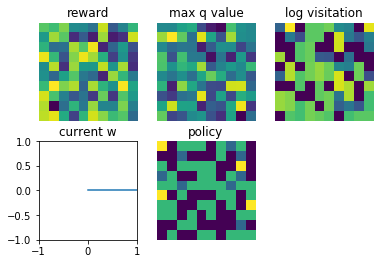

In [0]:
#@title animated visualization of intrinsic rewards and value function, sweeping over 2D w's
w_gran = 50
def pol2cart(rho, angle):
  x_coord = rho * np.cos(angle)
  y_coord = rho * np.sin(angle)
  return(x_coord, y_coord)
eval_feed_dict = {}
eval_feed_dict[s_ph] = np.arange(num_states)[np.newaxis]
x, y = pol2cart(1, np.linspace(0, 2*np.pi, w_gran))
all_w = np.dstack((x, y))[0]
if phi_dim > 2:
  all_w = np.concatenate([all_w, np.zeros([w_gran, phi_dim-2])], -1)
per_state_phi = sess.run(phi, feed_dict=eval_feed_dict)[0]
for i in range(w_gran):
  eval_feed_dict[w_ph] = np.tile(all_w[i][np.newaxis, np.newaxis],
                                 [1, num_states, 1])
  per_state_q = sess.run(gpi_q, feed_dict=eval_feed_dict)[0]
  max_value_img = np.mean(per_state_q, -1).reshape([grid_size, grid_size])
  policy = np.argmax(per_state_q, -1)
  state_visit = np.ones([num_states])
  s = reset(size=1000)
  for t in range(traj_len):
    s = step(s, policy[s])
    visit, count = np.unique(s, return_counts=True)
    state_visit[visit] += count
  clear_output(wait=True)
  plt.figure(0)
  plt.subplot(231)
  plt.title('reward')
  plt.axis('off')
  plt.imshow(np.dot(per_state_phi, all_w[i]).reshape(
      [grid_size, grid_size]), interpolation='none', aspect='equal')
  plt.subplot(232)
  plt.title('max q value')
  plt.axis('off')
  plt.imshow(max_value_img, interpolation='none', aspect='equal')
  plt.subplot(233)
  plt.title('log visitation')
  plt.axis('off')
  plt.imshow(np.log(state_visit.reshape(
      [grid_size, grid_size])), interpolation='none', aspect='equal')
  plt.subplot(234)
  plt.title('current w')
  plt.plot([0, all_w[i, 0]], [0, all_w[i, 1]])
  plt.xlim([-1, 1])
  plt.ylim([-1, 1])
  plt.subplot(235)
  plt.title('policy')
  plt.axis('off')
  plt.imshow(policy.reshape(
      [grid_size, grid_size]), interpolation='none', aspect='equal')
  plt.show()

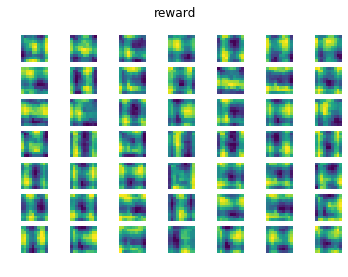

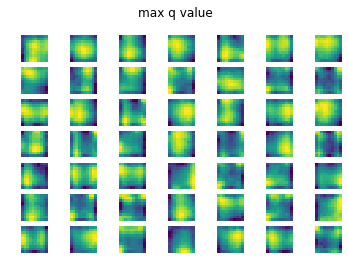

In [0]:
#@title static visualization of intrinsic rewards and value function, sweeping over 2D w's
plot_size = 7
w_gran = int(plot_size**2)
eval_feed_dict = {}
eval_feed_dict[s_ph] = np.arange(num_states)[np.newaxis]
x, y = pol2cart(1, np.linspace(0, 2*np.pi, w_gran))
all_w = np.dstack((x, y))[0]
if phi_dim > 2:
  all_w = np.concatenate([all_w, np.zeros([w_gran, phi_dim-2])], -1)
per_state_phi = sess.run(phi, feed_dict=eval_feed_dict)[0]
for i in range(w_gran):
  cur_w = sample_sphere(size=[1])
  eval_feed_dict[w_ph] = np.tile(cur_w[np.newaxis], [1, num_states, 1])
  per_state_q = sess.run(gpi_q, feed_dict=eval_feed_dict)[0]
  max_value_img = np.mean(per_state_q, -1).reshape([grid_size, grid_size])
  plt.figure(0)
  plt.suptitle('reward')
  plt.subplot(plot_size, plot_size, i+1)
  plt.axis('off')
  plt.imshow(np.dot(per_state_phi, cur_w[0]).reshape(
      [grid_size, grid_size]), interpolation='none', aspect='equal')
  plt.figure(1)
  plt.suptitle('max q value')
  plt.subplot(plot_size, plot_size, i+1)
  plt.axis('off')
  plt.imshow(max_value_img, interpolation='none', aspect='equal')

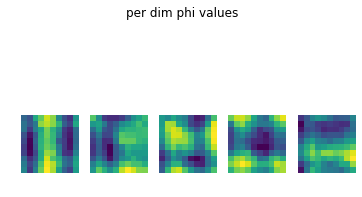

In [0]:
#@title visualize each feature dimensions per state
plt.figure()
plt.suptitle('per dim phi values')
for j in range(phi_dim):
  plt.subplot(1, phi_dim, j+1)
  plt.axis('off')
  plt.imshow(per_state_phi[:, j].reshape(
      [grid_size, grid_size]), interpolation='none', aspect='equal')

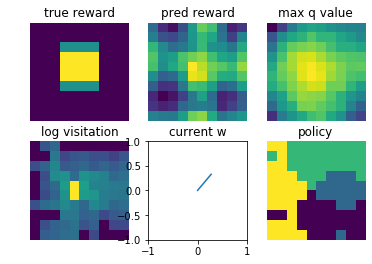

In [0]:
#@title fast inference on a random reward function
r = np.zeros([grid_size, grid_size])
num_boxes = 2  # @param {type: 'integer'}
box_size = 4  # @param {type: 'integer'}
for _ in range(num_boxes):
  box_c = np.random.randint(grid_size-box_size)
  box_r = np.random.randint(grid_size-box_size)
  r[box_r: box_r+box_size, box_c: box_c+box_size] += 1.0
r = np.reshape(r, [num_states])
sol, res, _, _ = np.linalg.lstsq(per_state_phi, r)
sol /= np.linalg.norm(sol)
eval_feed_dict[w_ph] = np.tile(sol[np.newaxis, np.newaxis], [1, num_states, 1])
per_state_q = sess.run(gpi_q, feed_dict=eval_feed_dict)[0]
max_value_img = np.mean(per_state_q, -1).reshape([grid_size, grid_size])
policy = np.argmax(per_state_q, -1)
state_visit = np.ones([num_states])
s = reset(size=1000)
for t in range(traj_len):
  s = step(s, policy[s])
  visit, count = np.unique(s, return_counts=True)
  state_visit[visit] += count
plt.figure(0)
plt.subplot(231)
plt.title('true reward')
plt.axis('off')
plt.imshow(r.reshape(
    [grid_size, grid_size]), interpolation='none', aspect='equal')
plt.subplot(232)
plt.title('pred reward')
plt.axis('off')
plt.imshow(np.dot(per_state_phi, sol).reshape(
    [grid_size, grid_size]), interpolation='none', aspect='equal')
plt.subplot(233)
plt.title('max q value')
plt.axis('off')
plt.imshow(max_value_img, interpolation='none', aspect='equal')
plt.subplot(234)
plt.title('log visitation')
plt.axis('off')
plt.imshow(np.log(state_visit.reshape(
    [grid_size, grid_size])), interpolation='none', aspect='equal')
plt.subplot(235)
plt.title('current w')
plt.plot([0, sol[0]], [0, sol[1]])
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.subplot(236)
plt.title('policy')
plt.axis('off')
plt.imshow(policy.reshape(
    [grid_size, grid_size]), interpolation='none', aspect='equal')